# Disease prediction forecast

## Data from patients was in json. Information included hospital visit dates, ICD and CPT codes along with diagnosis for multiple months and years. Goal was to predict if a patient will develop the disease in 2017 based on the information from all previous years

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from pandas.io.json import json_normalize
import json
from datetime import datetime

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.scorer import make_scorer
from sklearn import linear_model, decomposition



# 1. Experimental setup/design

In [32]:
# load data from local folder
ls = []
with open('train.txt') as f:
    for line in f:
        ls.append(json.loads(line))
len(ls)

73597

## Extract demographic information from all patients to dataframe

In [33]:
df_ptid=[]
for i in range(len(ls)):
    each_row=ls[i]['patient_id']
    df_ptid.append(each_row)

df_ptid=pd.DataFrame(df_ptid)


df_bday=[]
for i in range(len(ls)):
    each_row=ls[i]['bday']
    df_bday.append(each_row)

df_bday=pd.DataFrame(df_bday)


df_Gen=[]
for i in range(len(ls)):
    each_row=ls[i]['is_male']
    df_Gen.append(each_row)

df_Gen=pd.DataFrame(df_Gen) 


df_DM=[]
for i in range(len(ls)):
    each_row=ls[i]['tag_dm2']
    df_DM.append(each_row)
    
df_DM=pd.DataFrame(df_DM)    

df_id_bday_Gen_DM = pd.concat([df_ptid,df_bday,df_Gen,df_DM], axis=1, join_axes=[df_ptid.index])
df_id_bday_Gen_DM.columns=['ptID','bday','Gender','DM']



In [34]:
len(df_id_bday_Gen_DM['ptID'].unique()) # check for duplication patient ids

73597

In [36]:
df_id_bday_Gen_DM.isnull().any() # check for missing data


ptID      False
bday      False
Gender    False
DM        False
dtype: bool

In [37]:
df_id_bday_Gen_DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73597 entries, 0 to 73596
Data columns (total 4 columns):
ptID      73597 non-null object
bday      73597 non-null object
Gender    73597 non-null bool
DM        73597 non-null object
dtypes: bool(1), object(3)
memory usage: 1.8+ MB


In [38]:
# convert columns values to numerics
df_id_bday_Gen_DM['ptID'] = df_id_bday_Gen_DM['ptID'].str.replace('pat_','')
df_id_bday_Gen_DM['ptID']= pd.to_numeric(df_id_bday_Gen_DM['ptID'])

df_id_bday_Gen_DM['Gender']*=1

In [39]:
# compute age of patients
df_id_bday_Gen_DM['bday']=pd.to_datetime(df_id_bday_Gen_DM['bday'])
df_id_bday_Gen_DM['DM']=pd.to_datetime(df_id_bday_Gen_DM['DM'])
now = datetime.now()
df_id_bday_Gen_DM['age'] = (now - df_id_bday_Gen_DM['bday']).astype('<m8[Y]')
df_id_bday_Gen_DM['age']=df_id_bday_Gen_DM['age'].astype(int)

In [40]:
# create patient cohort
claim=[0]*len(df_id_bday_Gen_DM['DM'])
for tag in range(len(df_id_bday_Gen_DM['DM'])):
    if df_id_bday_Gen_DM['DM'][tag].year ==2017:
        claim[tag]= 1
    elif df_id_bday_Gen_DM['DM'][tag].year == 2013 or df_id_bday_Gen_DM['DM'][tag].year == 2014 or df_id_bday_Gen_DM['DM'][tag].year == 2015 or df_id_bday_Gen_DM['DM'][tag].year == 2016:
        claim[tag]= -1

claim=pd.DataFrame(claim)     

df_id_bday_Gen_DM ['claim']=claim
df_id_bday_Gen_DM['claim'].value_counts()

 0    70110
 1     3410
-1       77
Name: claim, dtype: int64

In [41]:
df_SUMM_0=df_id_bday_Gen_DM.drop(['bday','DM'], axis=1)
df_SUMM_0.head()
#df_SUMM_0.to_csv('SUMM_0.csv')

,ptID,Gender,age,claim
0,0,0,58,0
1,3,0,15,0
2,5,0,29,0
3,6,0,60,0
4,7,0,24,0


## Find unique observations for each patient in dataframe:
   ### no interpretation = -1, Normal = 0, Abnormal = 1, Low 'L' = 3, High 'H' = 5

In [42]:
nPatients = len(ls)
df_OBS = []
for i in range(nPatients):
    for key1, value1 in ls[i]['observations'].items():
        for j in range(len(value1)):
            if value1[j]['code']:
                df_OBS.append(value1[j]['code'])

df_OBS = pd.DataFrame(df_OBS, columns=['code'])
print(df_OBS.head(5))
print(df_OBS.shape)

codes_unq = pd.DataFrame(df_OBS['code'].unique())
codes_unq.columns = ['obs_unq']
print(codes_unq.head(5))
print(codes_unq.shape)

            code
0  loinc_13457-7
1   loinc_1742-6
2   loinc_1751-7
3   loinc_1759-0
4  loinc_17861-6
(4169499, 1)
         obs_unq
0  loinc_13457-7
1   loinc_1742-6
2   loinc_1751-7
3   loinc_1759-0
4  loinc_17861-6
(3913, 1)


In [43]:
ls_OBS_codes_unq = codes_unq['obs_unq'].tolist()

temparr1 = -1*np.ones(shape=(nPatients,len(ls_OBS_codes_unq)))
df_SUMM_1 = pd.DataFrame(temparr1,index=range(0,nPatients),columns=ls_OBS_codes_unq)

for i in range(nPatients):
    for key1, value1 in ls[i]['observations'].items():
        for j in range(len(value1)):
            if value1[j]['code']:
                if value1[j]['interpretation'] == 'N':
                    df_SUMM_1.set_value(i, value1[j]['code'], 0)
                elif value1[j]['interpretation'] == 'A':
                    df_SUMM_1.set_value(i, value1[j]['code'], 1)
                elif value1[j]['interpretation'] == 'L':
                    df_SUMM_1.set_value(i, value1[j]['code'], 3)
                elif value1[j]['interpretation'] == 'H':
                    df_SUMM_1.set_value(i, value1[j]['code'], 5)

print(df_SUMM_1.shape)
#df_SUMM_1.to_csv('SUMM_1.csv')

(73597, 3913)


## Find unique resources for each patient in dataframe:
   ### no codes = 0, Diagnosis = 1. I have grouped all diseases to their root code by removing the numbers after decimals to reduce the number of columns and hence feature vectors. Ideally given computing resources I would have liked to remove the redundant diagnosis codes between ICD9, ICD10 and CPT with cohorts

In [44]:
nPatients = len(ls)
df_RES = []
for i in range(nPatients):
    for key1, value1 in ls[i]['resources'].items():        
        for j in range(len(value1)): 
            if value1[j]:
                df_RES.append(value1[j])

df_RES = pd.DataFrame(df_RES, columns=['diag_codes'])
print(df_RES.shape)

dcodes_unq = pd.DataFrame(df_RES['diag_codes'].unique())
dcodes_unq.columns = ['res_unq']
print(dcodes_unq.head(5))
print(dcodes_unq.shape)

dcodes_unq = dcodes_unq['res_unq'].str.split('.', expand=True)
dcodes_unq.columns = ['a','b']
dcodes_unq = pd.DataFrame(dcodes_unq['a'].unique())
dcodes_unq.columns = ['res_unq']

print(dcodes_unq.head(5))
print(dcodes_unq.shape)


(11112574, 1)
       res_unq
0    cpt_99213
1  icd9_V85.23
2    cpt_87210
3  icd9_789.03
4    cpt_87591
(39337, 1)
     res_unq
0  cpt_99213
1   icd9_V85
2  cpt_87210
3   icd9_789
4  cpt_87591
(11255, 1)


In [45]:
ls_RES_codes_unq = dcodes_unq['res_unq'].tolist()


temparr2 = np.zeros(shape=(nPatients,len(ls_RES_codes_unq)))
df_SUMM_2 = pd.DataFrame(temparr2, index=range(0,nPatients), columns=ls_RES_codes_unq)

for i in range(nPatients):
    for key1, value1 in ls[i]['resources'].items():
        for j in range(len(value1)):
            if value1[j]:
                splitval=value1[j].split(".")
                df_SUMM_2.set_value(i, splitval[0], 1)

print(df_SUMM_2.shape)
#df_SUMM_2.to_csv('SUMM_2.csv')

(73597, 11255)


## I had to use only first 10000 data points as I do not have enough memory to run the entire dataset (I had to save into csv and run in a different kernel because I didnt have enough memory)

In [2]:
df_SUMM_0 = pd.read_csv('SUMM_0.csv', nrows = 10000)
df_SUMM_1 = pd.read_csv('SUMM_1.csv', nrows = 10000)
df_SUMM_2 = pd.read_csv('SUMM_2.csv', nrows = 10000)


df_all=pd.concat([df_SUMM_0,df_SUMM_1,df_SUMM_2], axis=1, join_axes=[df_SUMM_0.index])

### Remove the prior cohort

In [3]:
df=df_all.loc[df_all['claim'] != -1]

In [4]:
del df_all, df_SUMM_0, df_SUMM_1, df_SUMM_2
df.head()

,Unnamed: 0,ptID,Gender,age,claim,Unnamed: 0,loinc_13457-7,loinc_1742-6,loinc_1751-7,loinc_1759-0,...,cpt_G0282,cpt_61597,cpt_93750,cpt_33979,cpt_K0037,cpt_A0432,cpt_59020,cpt_E0958,icd9_828,cpt_44660
0,0,0,0,58,0,0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,0,15,0,1,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,0,29,0,2,0.0,-1.0,-1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,6,0,60,0,3,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7,0,24,0,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X=df.drop(['claim','Unnamed: 0'], axis=1)
X.head()

,ptID,Gender,age,loinc_13457-7,loinc_1742-6,loinc_1751-7,loinc_1759-0,loinc_17861-6,loinc_1920-8,loinc_1975-2,...,cpt_G0282,cpt_61597,cpt_93750,cpt_33979,cpt_K0037,cpt_A0432,cpt_59020,cpt_E0958,icd9_828,cpt_44660
0,0,0,58,0.0,0.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,15,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0,29,0.0,-1.0,-1.0,3.0,3.0,-1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0,60,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0,24,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
y=df[['claim']].values.ravel()
del df

## I split the training set to check for the performance metrics of my predictive algorithm

In [7]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)


## Check for correlated features

In [ ]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 2. Feature design/feature selection

## Standardize the training data

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)

## Reduce number of features from 15171 columns using PCA
### I ran a pipeline to estimate the best components for PCA with logistic regression

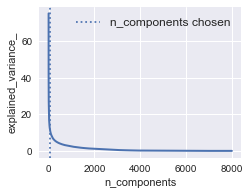

In [10]:
logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])


# Plot the PCA spectrum
pca.fit(X_train_standard)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train_standard, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [11]:
estimator.best_estimator_.named_steps['pca'].n_components

40

In [14]:
estimator.best_estimator_

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

### Looking at the graph and after multiple iterations I decided to use the first 1500 components of PCA

In [12]:
pca1 = PCA(n_components=1500)
train_features = pca1.fit_transform(X_train_standard)

### Plot to see if the first 2 components of PCA discriminate the data or not

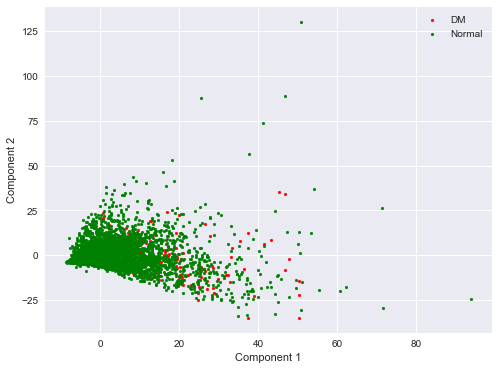

In [29]:
# Perform a PCA to further visualize the distribution of training data and classes
# from sklearn.decomposition import PCA

red = y_train==1
green = y_train==0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(8)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(train_features[red, 0], train_features[red, 1], c='r', s=8)
ax.scatter(train_features[green, 0], train_features[green, 1], c='g', s=8)
ax.axis('tight')
ax.legend(['DM', 'Normal'])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

### There dosen't seem to be much separation between the first two components. I believe including the entire dataset will improve performance

# 3. Model selection/tuning

### Find the best parameters for logistic regression on PCA transformed data

In [17]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid , cv=5)


# Fit it to the data
logreg_cv.fit(train_features, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 163789.3706954068}
Best score is 0.9258193645233925


# 4. Model performance evaluation (i.e how well it does along the metrics above)

### Training accuracy is 92.58%

In [21]:
X_test_standard = scaler.fit_transform(X_test)
test_features = pca1.fit_transform(X_test_standard)
class_pred = logreg_cv.predict(test_features)

In [23]:
print("Testing accuracy is: ", accuracy_score(y_test, class_pred))

Testing accuracy is:  0.833916958479


### Testing accuracy is 83.39%

## Plot of confusion matrix for misclassifications

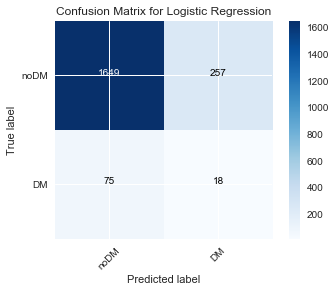

In [24]:

from sklearn.metrics import confusion_matrix
import itertools
cnf_mat = confusion_matrix(y_test, class_pred)

# Plot out
plt.figure()
plt.imshow(cnf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.colorbar()
classNames = ['noDM', 'DM']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

# Generate text showing the number of correctly and mis-classified samples in each cell
fmt = 'd'
thresh = cnf_mat.max() / 2.
for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
    plt.text(j, i, format(cnf_mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if cnf_mat[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

## ROC curve

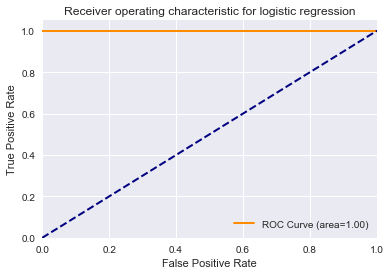

In [28]:
preds = logreg_cv.predict_proba(test_features)[:,1]

y_test[y_test==0]= 0
y_test[y_test==1]= 1
class_pred[y_test==0]= 0
class_pred[y_test==1]= 1

fpr, tpr, _ = roc_curve(y_test, class_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label="ROC Curve (area=%0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

# 5. A short write-up (2-3 paragraph) of your approach.

### The classifier does not perform well. I had tried Random Forest too with and without PCA they all give similar results. Very high accuracy but poor precision and recall metrics

### Ideally I would like to reduce the feature vectors by removing redundant information between ICD9, ICD 10 and CPT codes. Also I would group or remove redundant and irrelevant laboratory test results which should improve the performance of the predictions. However I am limited by what I can do within hardware and resource constraints.